In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import os
import numpy as np

In [3]:
import matplotlib.pyplot as plt
# from IPython import display

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

In [71]:
from keras import backend as K

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Lambda
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adam, SGD, Adamax

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

#### Custom Functions

In [8]:
import pprint
import os
import sys
sys.path.append('../')
from src.load_data import load_data

In [9]:
from src.callbacks import PlotCurves
from src.custom_functions import f1_macro, f1_micro 
from src.load_data import load_data

### Load Data

In [10]:
train_data, valid_data, test_data, metadata = load_data()

#### Number of Sentences

In [11]:
print('Max number of sentences in an article:',
      max([len(article['sentences']) for article in (train_data + valid_data + test_data)]))

Max number of sentences in an article: 58


### Prepare data

In [43]:
def split_data(data_, to_categorize):
    
    X = np.array([sentence['sentence'].replace('\n', '').strip() 
                  for article in data_ 
                  for sentence in article['sentences']])

    y = np.array([sentence['label'] 
                  for article in data_
                  for sentence in article['sentences']])

    if to_categorize:
        y = to_categorical(y)
    
    return X, y

In [44]:
X_tra, y_tra = split_data(train_data, True)
X_val, y_val = split_data(valid_data, True)
X_test, y_test = split_data(test_data, False)

### TFIDF Vectors

In [45]:
number_stopwords = [str(i) for i in range(10001)] + ['0'+ str(i) for i in range(100)] + ['000']

In [46]:
X_tfidf = np.concatenate([X_tra, X_val])

In [47]:
vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.12, 
                             max_features=None, 
                             stop_words=number_stopwords)
vectorizer = vectorizer.fit(X_tfidf)

In [48]:
X_tra = vectorizer.transform(X_tra)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [60]:
X_tra.shape, X_tra[0]

((3582, 3010), <1x3010 sparse matrix of type '<class 'numpy.float64'>'
 	with 40 stored elements in Compressed Sparse Row format>)

## Build Model

In [136]:
def build_flat_model_0():
    
    input_text = Input(shape=(3010,))
    dense = Dense(512, activation='relu')(input_text)
    dense = Dense(256, activation='relu')(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_1():
    
    input_text = Input(shape=(3010,))
    dense = Dense(256, activation='relu')(input_text)
    dense = Dense(128, activation='relu')(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)


In [137]:
learningrate=0.0001
optimizer = Adam(lr=learningrate)
optimizer_str = 'Adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [138]:
model_name = 'RQ1_TFIDF_flat_model_1_' + optimizer_str + '_lr_' + str(learningrate) + '_loss_' + loss # + '_with_learnin_rate_reduction'
model = build_flat_model_1()
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3010)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               770816    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 258       
Total params: 803,970
Trainable params: 803,970
Non-trainable params: 0
_________________________________________________________________


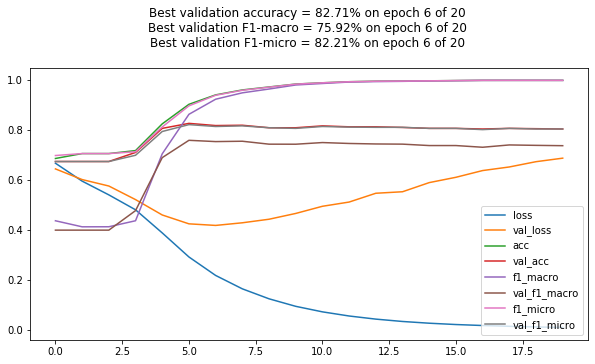

In [139]:
## Flat Model Fit
model.fit(X_tra, y_tra, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
          callbacks=[PlotCurves(model_name=model_name)
#                      , learning_rate_reduction
                    ])

## Load the best Model

In [140]:
model_name 

'RQ1_TFIDF_flat_model_1_Adam_lr_0.0001_loss_binary_crossentropy'

In [141]:
best_model = load_model('Model/' + model_name + '/' + model_name + '_best_f1_macro_model.h5', 
                        custom_objects={'tf': tf, 'f1_macro':f1_macro, 'f1_micro':f1_micro})

### Validation Set


In [142]:
results_file = os.path.join('Model/' + model_name, 'model_results_file.txt')
        
with open(results_file, 'w') as f:
    f.write('\n----------------\n')

In [143]:
y_val_true = np.array([sentence['label'] for article in valid_data 
                                 for sentence in article['sentences']])

y_val_preds = best_model.predict(X_val, batch_size=32)
y_val_preds = np.argmax(y_val_preds, axis=1)

print(classification_report(y_val_true, y_val_preds))
with open(results_file, 'a') as f:
    f.write(classification_report(y_val_true, y_val_preds))
    f.write('\n')

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       269
           1       0.79      0.64      0.71       130

   micro avg       0.83      0.83      0.83       399
   macro avg       0.82      0.78      0.79       399
weighted avg       0.82      0.83      0.82       399



In [144]:
with open(results_file, 'a') as f:
    f.write(str(scikit_f1_score(y_val_true, y_val_preds,average='macro')))
    f.write('\n')
    
print(scikit_f1_score(y_val_true, y_val_preds,average='macro'))

0.7919126261290201


### Test

In [145]:
y_preds = best_model.predict(X_test, batch_size=32)
y_preds = np.argmax(y_preds, axis=1)

In [146]:
### build_flat_model_1 results
print(classification_report(y_test, y_preds))
with open(results_file, 'a') as f:
    f.write(classification_report(y_test, y_preds))
    f.write('\n')

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       325
           1       0.72      0.46      0.56       116

   micro avg       0.81      0.81      0.81       441
   macro avg       0.77      0.70      0.72       441
weighted avg       0.80      0.81      0.79       441



In [147]:
with open(results_file, 'a') as f:
    f.write(str(scikit_f1_score(y_test, y_preds,average='macro')))
    f.write('\n')
    
print(scikit_f1_score(y_test, y_preds,average='macro'))

0.7182537268025555
